In [45]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy #Hope you don't lower my grade for that, I was just having problems with the shallow and deep copies.

%matplotlib inline

First lets read the data and let's check the linearity of each variable against the outcome of ATP. Is important to check it, because if the data follows a non-linear relation, we cannot estimate the parameters of the model. Although this is take as granted when the model is defined as linear, is important to do a previous check.

In [62]:
data = pd.read_table('./diet_and_atp.tsv')
data_original = copy.deepcopy(data)
data = data.drop(columns="ATP")
data
data_original

,Protein,Carbohydrates,Fat,ATP
0,1.95,6.92,0.02,9.44
1,0.64,2.65,0.15,4.04
2,1.82,0.98,0.21,3.72
3,1.80,4.69,0.23,7.54
4,0.93,4.22,0.02,5.70
...,...,...,...,...
94,1.83,5.69,0.15,8.60
95,1.77,6.33,0.07,8.66
96,1.15,4.88,0.27,6.80
97,1.30,3.91,0.03,5.46


Text(0.5, 0, 'Type of Diet')

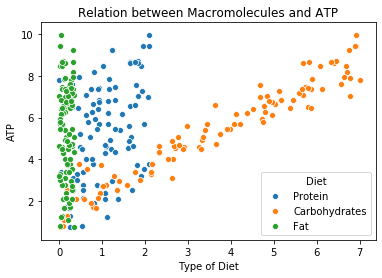

In [43]:
sns.scatterplot(x=data.Protein,y=data.ATP)
sns.scatterplot(x=data.Carbohydrates,y=data.ATP)
sns.scatterplot(x=data.Fat,y=data.ATP)
plt.legend(title='Diet', loc='lower right', labels=['Protein', 'Carbohydrates','Fat'])
plt.title("Relation between Macromolecules and ATP")
plt.xlabel("Type of Diet")


With that plot we can see that each variable follows with more or less correlation a linear relation, but the important thing is that none of them follows a non-linear relation. Therefore we can proceed to estimate the parameters for this multiple linear regression model with Least Squares method.

Let's think how to do that. According to the model we can describe the error as

error = y(real)-y(predicted) = y(real)-(a · Proteins +b · Carbohydrates + C · Fats)

What are we going to apply is that the vector of coefficients that minimize the error between the model and the observed data are calculated in the following way:

Let's name first our things.

Coefficients = (Xt · X) ^-1 · Xt * ATP

So let's calculate that


In [55]:
# First we store the Y variable data, but for that let's make a deep copy of the original data
ATP = list(data_original.ATP)
Protein = list(data_original.Protein)

In [59]:
# Let's compute the transpose matrix.
data_transposed = data.T
data_transposed

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
Protein,1.95,0.64,1.82,1.80,0.93,1.60,1.17,0.30,1.72,0.23,...,0.67,1.31,1.00,1.92,0.94,1.83,1.77,1.15,1.30,0.56
Carbohydrates,6.92,2.65,0.98,4.69,4.22,2.71,5.88,5.80,2.34,3.66,...,4.76,2.33,1.03,1.29,4.96,5.69,6.33,4.88,3.91,0.90
Fat,0.02,0.15,0.21,0.23,0.02,0.02,0.32,0.13,0.31,0.31,...,0.02,0.35,0.31,0.01,0.16,0.15,0.07,0.27,0.03,0.16


Now we need to generate the inverse of the multiplication of the transpose matrix against the datamatrix

In [70]:
intermediate = (data_transposed.dot(data))

Data has dimension 3 x 98 and data_transposed has 98 x 3. Therefore the dot product has dimension 3x3, meaning that the multiplication is correct. Now we need to generate the inverse matrix for this one.

For obtaining the inverse of a matrix, the determinant has to be different than 0, due to:

If det(A) != 0
   A-1 = adj(A)/det(A)
Else:
    "Matrix does not have inverse"

Do let's check the determinant.

In [91]:
#Let's create the inversion of the 3x3 matrix. For this we will generate a function called inversion

def inversion(m):    
    m1, m2, m3, m4, m5, m6, m7, m8, m9 = m.flatten()
    determinant = m1*m5*m9 + m4*m8*m3 + m7*m2*m6 - m1*m6*m8 - m3*m5*m7 - m2*m4*m9  
    d = {"Protein":[(m5*m9-m6*m8)/determinant, (m3*m8-m2*m9)/determinant, (m2*m6-m3*m5)/determinant],
           "Carbohydrates":[(m6*m7-m4*m9)/determinant, (m1*m9-m3*m7)/determinant, (m3*m4-m1*m6)/determinant],
           "Fat":[(m4*m8-m5*m7)/determinant, (m2*m7-m1*m8)/determinant, (m1*m5-m2*m4)/determinant]}
    return pd.DataFrame(data=d)

inverted = inversion(intermediate.values)

inverted

,Protein,Carbohydrates,Fat
0,0.020660,-0.003353,-0.036916
1,-0.003353,0.001626,-0.010494
2,-0.036916,-0.010494,0.581092


Finally we just need to multiply that for the transposed and for the dependent variable vector.

In [96]:
a,b,c = inverted.dot(data.T).dot(ATP)
print ("The value for A is:",round(a,4))
print ("The value for B is:",round(b,4))
print ("The value for C is:",round(c,4))

The value for A is: 1.093
The value for B is: 1.0505
The value for C is: 1.9063


And therefore the model is the next one:
### ATP = 1.093 · Proteins + 1.050 · Carbohydrates + 1.906 · Fats + error. 

Let's compute now how much error has this model. For this we need to compute the quantity of ATP that is generated in each observation according the model (y^)

In [105]:
predicted_ATP = list()
error = list()

for _i in range(0,len(data.Protein)):
    predicted_ATP.append(a * list(data.Protein)[_i] + b * list(data.Carbohydrates)[_i] + c * list(data.Fat)[_i])
    
for _x in range(0,len(ATP)):
    error.append(ATP[_x] - predicted_ATP[_x])
    
#Let's compute the RMSE of the model

RMSE = sum(i**2 for i in error)/len(error)
print ("The model with the estimated coefficients has an RMSE of:", RMSE)

The model with the estimated coefficients has an RMSE of: 0.0947829944776766
